## Importing OS

In [21]:
# basic imports
import os
from tqdm import tqdm

# numpy
import numpy as np

# plotting
%matplotlib inline
import matplotlib.pyplot as plt

# sklearn
from sklearn.manifold import TSNE

# torch
import torch
from torch.nn import Linear
import torch.nn.functional as F

# PyG
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import NeighborLoader

# data_new.py
import importlib
import data_new
from data_new import SeparatedDataset
import utils
from utils import EWC, ewc_train, normal_train

In [4]:
os.environ['TORCH'] = torch.__version__

## Graph Plotting function

In [5]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Simple EDA for Planetoid cora

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('===========================================================================================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [7]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of validation nodes: 500
Number of testing nodes: 1000
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Preparing loaders

In [8]:
def getGraphDataLoader(data_train, task_masks, batch_size, neighbors_arr):
        '''
        This function takes in a graph data object the required batch_size 
        and neighbors_arr and returns a loader
        '''
        loader=NeighborLoader(
            data_train,    # taking in data_train
            input_nodes=task_masks,
            num_neighbors=neighbors_arr,  
            batch_size=batch_size,
            replace=False,
            shuffle=True
        )
        return loader

## GCN model

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels) # does Message computation + Neighborhood aggregation internally
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Train and test methods

In [10]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    # epoch wise
    for _ in tqdm(range(epochs)):
        total_loss = 0
        total = 0
        # batch wise
        for batch in train_loader:
            optimizer.zero_grad()  # Clear gradients.
            out = model(batch.x, batch.edge_index)  # Perform a single forward pass.
            y_act = batch.y[:batch.batch_size]
            out = out[:batch_size]
            loss = criterion(out, y_act)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients
            total_loss += loss.item()
            total += y_act.size(0)
        # if epoch % 5 == 0:
        #     print("Epoch :", epoch+1, ", Loss :", total_loss/total)

In [11]:
def test(model, test_loader):
    model.eval()
    test_correct = 0
    total_elements = 0
    for batch in test_loader:
        
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        
        pred = pred[:batch.batch_size]
        y_act = batch.y[:batch.batch_size]
        
        test_correct += (pred == y_act).sum().item()
        total_elements += batch.batch_size
        
    test_acc = test_correct/total_elements
    return test_acc

## Running the model

In [42]:
epochs = 40
batch_size = 10
neighbors_arr = [4, 3]

In [43]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [44]:
train_loader = getGraphDataLoader(data, data.train_mask | data.val_mask, batch_size, neighbors_arr)

In [45]:
test_loader = getGraphDataLoader(data, data.test_mask, batch_size, neighbors_arr)

In [46]:
train(model, train_loader, criterion, optimizer, epochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.31it/s]


In [47]:
test_accuracy = test(model, test_loader)

In [48]:
test_accuracy

0.841

##  EWC

In [13]:
#parameters for EWC
sample_size = 200
epochs = 10
num_tasks = 2
batch_size = 4
neighbors_arr = [4, 2]

## Getting data for EWC

In [14]:
# As data is less here we merge train and val data
# make a separatedDataset object and get the masks for all tasks
# get train_mask_arr and test_mask_arr for differnt tasks
# get train_loader_arr and test_loader_arr for different tasks

In [15]:
final_train_mask = data.train_mask | data.val_mask
separatedDataset = SeparatedDataset(final_train_mask, num_tasks)
train_task_masks_arr, test_task_masks_arr = separatedDataset.train_test_split_ewc(0.1)
train_loader_arr, test_loader_arr = separatedDataset.preparingLoaders(data, batch_size, neighbors_arr, train_task_masks_arr, test_task_masks_arr)

## Training and testing method without EWC

In [53]:
import utils
importlib.reload(utils)
from utils import EWC, ewc_train, normal_train

In [54]:
def normal_train_ewc(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, weight=True):
    model.train()
    loss, acc = {}, {}
    for task in range(num_tasks):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, criterion, optimizer, train_loader_arr[task]))
            # testing for previous tasks as we progress
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader_arr[sub_task]))
        if task == 0 and weight:
            weight = model.state_dict()

    return loss, acc, weight

In [55]:
def test(model, test_loader):
    model.eval()
    test_correct = 0
    total_elements = 0
    for batch in test_loader:
        
        out = model(batch.x, batch.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        
        pred = pred[:batch.batch_size]
        y_act = batch.y[:batch.batch_size]
        
        test_correct += (pred == y_act).sum().item()
        total_elements += batch.batch_size
        
    test_acc = test_correct/total_elements
    return test_acc

In [56]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [57]:
loss, acc, weight = normal_train_ewc(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]


In [61]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)
    # possibility of an outlier in data reducing the y_lim to 3

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_tasks * epochs)), v)  

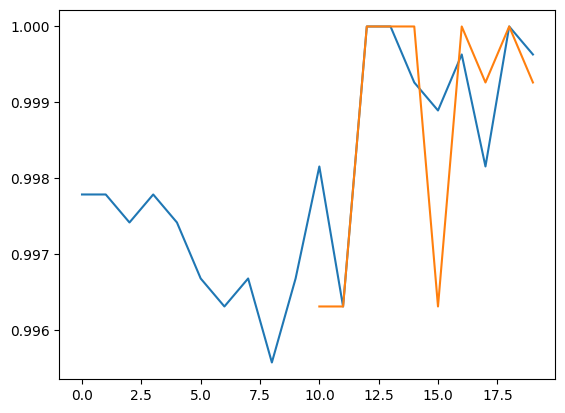

In [62]:
accuracy_plot(acc)

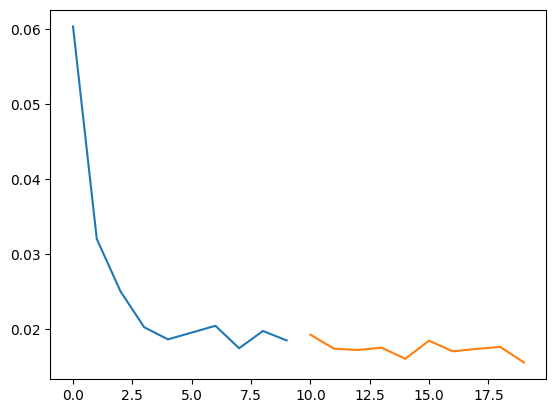

In [63]:
loss_plot(loss)

## Training and testing method with EWC

In [26]:
#train_task_masks_arr, test_task_masks_arr
import random

In [42]:
def ewc_process(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, importance, train_task_masks_arr, separatedDataset, weight=None):

    loss, acc, ewc = {}, {}, {}

    sample_size = 20
    
    for task in range(num_tasks):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, criterion, optimizer, train_loader_arr[task]))
                    acc[task].append(test(model, test_loader_arr[task]))
        else:
            # need to rewrite this using masking
            old_tasks = []
            for sub_task in range(task):
                # Or sample_size from each task
                old_tasks.extend(separatedDataset.get_sample(train_task_masks_arr, sample_size))
            # again select 200 randonly
            old_tasks = random.sample(old_tasks, k=sample_size)
            # get dataloader for oldtask
            old_tasks_mask = np.zeros_like(train_task_masks_arr[0])
            old_tasks_mask[old_tasks] = 1
            old_tasks_loader = getGraphDataLoader(data, old_tasks_mask, batch_size, neighbors_arr)          
            for _ in tqdm(range(epochs)):
                # start EWC training
                # prepare EWC object first so pass old data and model
                loss[task].append(ewc_train(model, criterion, optimizer, train_loader_arr[task], EWC(model, old_tasks_loader, criterion, np.sum(old_tasks_mask)), importance))
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader_arr[sub_task]))

    return loss, acc

In [63]:
importlib.reload(data_new)
import data_new
from data_new import SeparatedDataset
importlib.reload(utils)
import utils
from utils import EWC, ewc_train, normal_train

In [64]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [65]:
importance = 1000
epochs = 10

In [66]:
loss_ewc, acc_ewc = ewc_process(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, importance, train_task_masks_arr, separatedDataset)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]


In [67]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)
    # possibility of an outlier in data reducing the y_lim to 3

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_tasks * epochs)), v)  

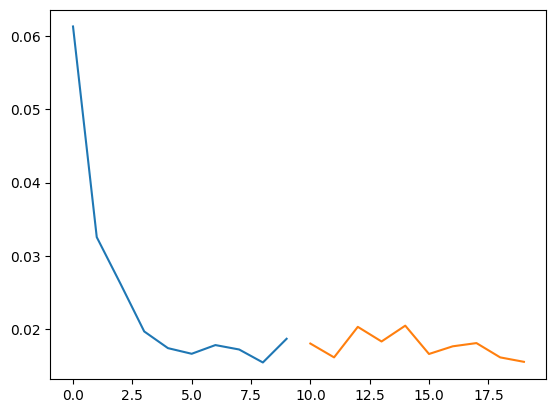

In [68]:
loss_plot(loss_ewc)

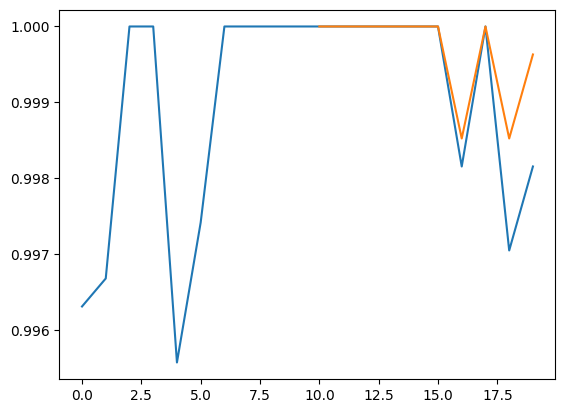

In [69]:
accuracy_plot(acc_ewc)

In [ ]:

# how to test

# For normal train
# train a model on task 1 and then train same model on task 2
# plot the loss 
# plot the accuracy -> for dataset of both the tasks

# For EWC train
# train a model on task 1 and then train same model on task 2 using EWC penalty 
# plot the loss
# plot the accuracy -> for dataset of both the tasks